# 차량 EV 경진대회

## Data Import

In [1]:
import pandas as pd
import os 

train = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/CarEV/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/CarEV/test.csv')
submit = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/CarEV/sample_submission.csv')

In [2]:
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


In [3]:
test.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0
2,TEST_002,B사,i5,Brand New,NaN,RWD,7197,7,Yes,0
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1
4,TEST_004,K사,EV6,Brand New,NaN,FWD,7597,10,No,0


In [4]:
submit.head()

,ID,가격(백만원)
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


In [5]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes,columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) *100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    
    return summ
summary(train)

data shape: (7497, 11)


,data type,#missing,%missing,#unique,min,max
ID,object,0,0.000000,7497,NaN,NaN
제조사,object,0,0.000000,7,NaN,NaN
모델,object,0,0.000000,21,NaN,NaN
차량상태,object,0,0.000000,3,NaN,NaN
배터리용량,float64,2711,36.161131,194,46.0,99.8
구동방식,object,0,0.000000,3,NaN,NaN
주행거리(km),int64,0,0.000000,6916,3.0,199827.0
보증기간(년),int64,0,0.000000,11,0.0,10.0
사고이력,object,0,0.000000,2,NaN,NaN
연식(년),int64,0,0.000000,3,0.0,2.0


In [6]:
cat_col = ['제조사','모델','차량상태','구동방식','사고이력']
con_col = ['배터리용량','주행거리(km)','보증기간(년)','연식(년)','가격(백만원)']

cat_col = []
bin_col = []
con_col = []

for i in train.columns:
    if train[i].nunique() > 21 :
        con_col.append(i)
    elif (train[i].nunique() <= 21) & (train[i].nunique() > 2):
        cat_col.append(i)
    else:
        bin_col.append(i)
        
con_col.remove('ID')
print('범주형 변수: ',cat_col)
print('이산형 변수: ',bin_col)
print('연속형 변수: ',con_col)

"한글을 인식하지 못할 상황을 대비한 전처리"


In [7]:
test['제조사'] = test['제조사'].apply(lambda x: x.replace('사',''))
train['제조사'] = train['제조사'].apply(lambda x: x.replace('사',''))
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


## EDA

In [8]:
df_c = train.copy()
df_c.drop('ID',axis=1,inplace=True)
df_c.head()

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,P,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,K,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,A,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,A,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,B,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


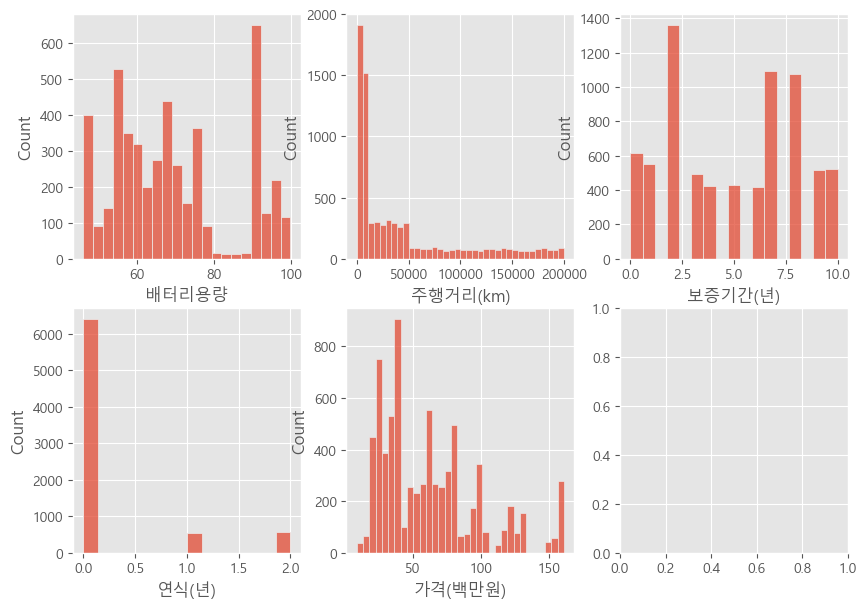

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.style.use('ggplot')

# 각 Feature의 분포도 plot
fig,ax = plt.subplots(2,3,figsize=(10,7))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.histplot(df_c[col],ax=ax[i])

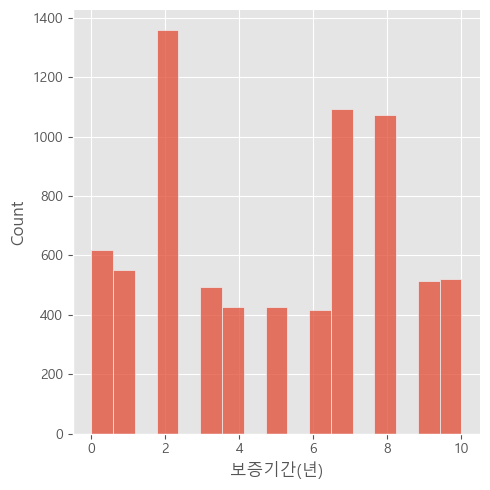

In [10]:
sns.displot(df_c['보증기간(년)'])

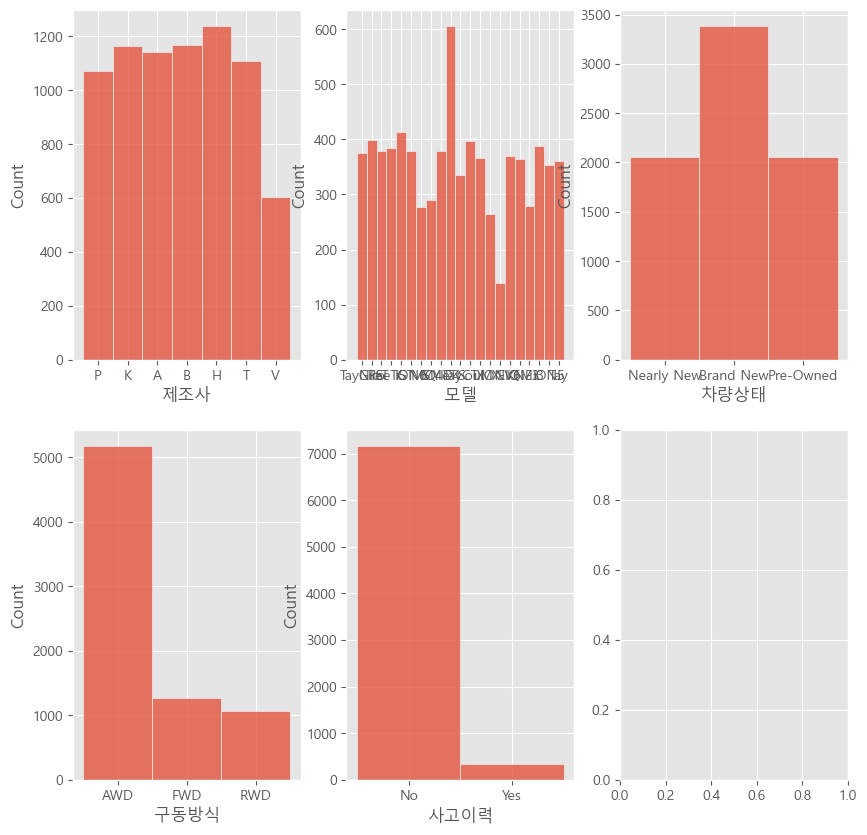

In [11]:
#범주형 변수의 분포
fig,ax = plt.subplots(2,3,figsize=(10,10))
ax = ax.flatten()
for i,col in enumerate(cat_col):
    sns.histplot(x=df_c[col],ax=ax[i])

### 0. 종속변수(가격)
- skewness:1
결측치 X

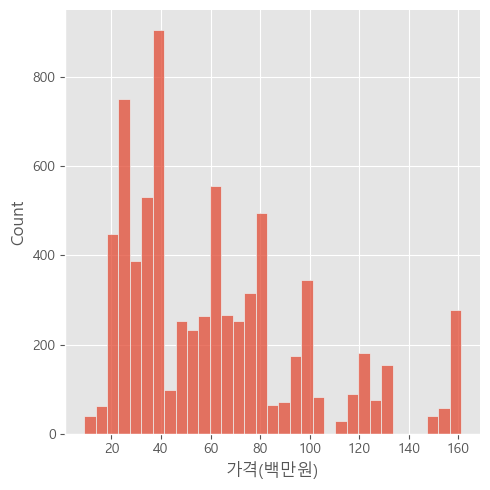

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.style.use('ggplot')

sns.displot(train['가격(백만원)'])

### 1. 제조사
- 각 제조사별 (7개)의 도수가 비슷함
- P 제조사가 가장 차량의 가격이 높다.

<Axes: xlabel='제조사', ylabel='가격(백만원)'>

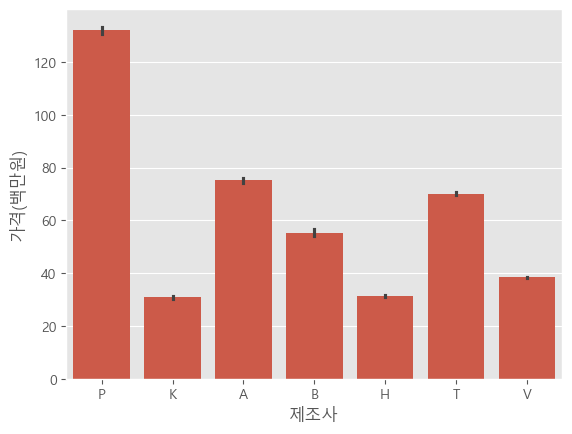

In [13]:
sns.barplot(y=train['가격(백만원)'],x=train['제조사'])

### 2. 모델
- 대체로 분포 균일
- 'TayGTS'모델의 값이 가장 높으며, IonicQ의 모델 가격이 가장 낮음



In [14]:
train['모델'].unique()

array(['TayGTS', 'Niro', 'eT', 'RSeTGT', 'i5', 'ION6', 'MS', 'MY', 'Q4eT',
       'ID4', 'TayCT', 'Soul', 'iX', 'MX', 'IONIQ', 'EV6', 'KNE', 'M3',
       'i3', 'ION5', 'Tay'], dtype=object)

<Axes: ylabel='가격(백만원)'>

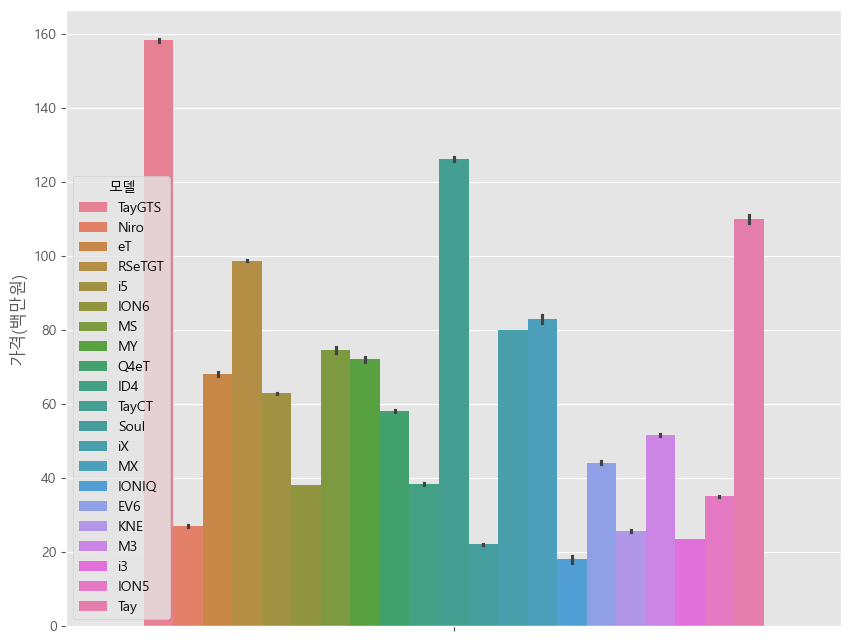

In [15]:
plt.figure(figsize=(10,8))
sns.barplot(y=train['가격(백만원)'],hue=train['모델'])

### 3. 차량상태
- 분포도 비슷하고, 차량상태에따른 가격 변동차이도 거의 없음.
- **'nearly-new'와 'pre-owned'의 차이점에 대한 궁금증** 
    - nearly-new 보다는 pre-owned가 더 많은 주행거리를 가지고 있음.
- 차량상태가 Brand New이어도 주행거리가 O이아니라 (거의 신형으로 생각)

<Axes: ylabel='가격(백만원)'>

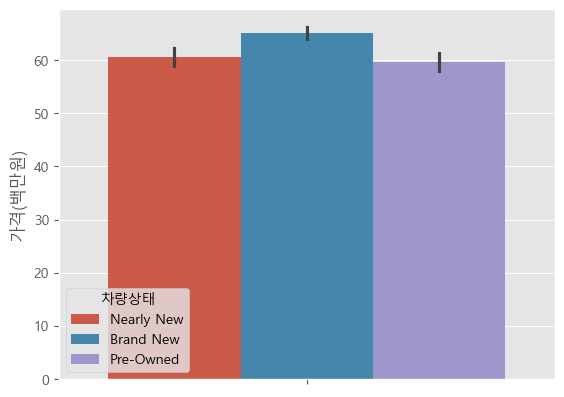

In [16]:
sns.barplot(y=train['가격(백만원)'],hue=train['차량상태'])

<Axes: xlabel='주행거리(km)', ylabel='Count'>

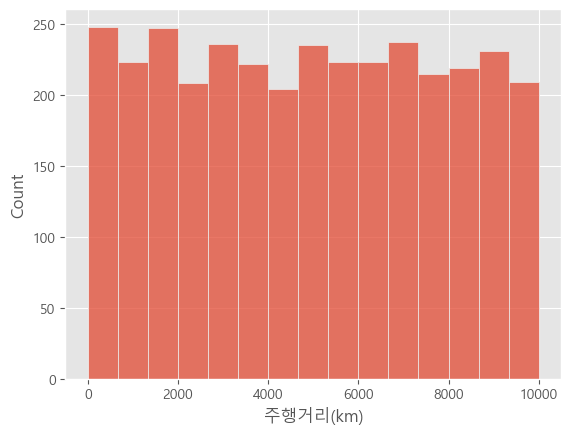

In [17]:
sns.histplot(train.loc[train['차량상태']=='Brand New']['주행거리(km)'])

Pre-Owned 최소 거리: 11477
nearly-new 최소 거리: 10004


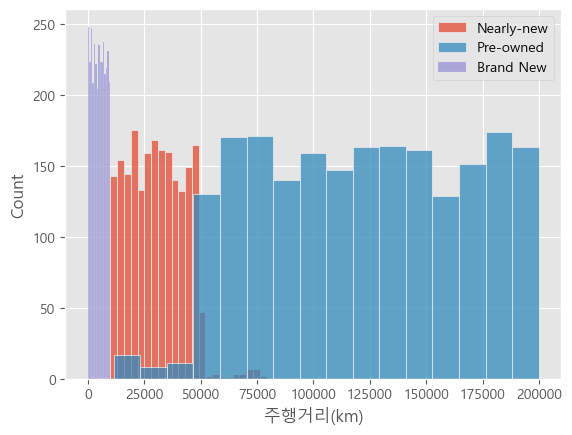

In [18]:
sns.histplot(train.loc[train['차량상태']=='Nearly New']['주행거리(km)'],label='Nearly-new')
sns.histplot(train.loc[train['차량상태']=='Pre-Owned']['주행거리(km)'],label='Pre-owned')
sns.histplot(train.loc[train['차량상태']=='Brand New']['주행거리(km)'],label='Brand New')

plt.legend()

print('Pre-Owned 최소 거리:',train.loc[train['차량상태']=='Pre-Owned']['주행거리(km)'].min())
print('nearly-new 최소 거리:',train.loc[train['차량상태']=='Nearly New']['주행거리(km)'].min())

### 4. 배터리용량 
- 용량이 69.397187인 도수가 가장 많은 부분을 차지.
- 대체로 배터리용량이 증가할 수록 가격도 상승하는 상관관계
- 주행거리와 큰 상관관계 / 배터리 용량이 클수록, 주행거리가 작음.

In [19]:
train['배터리용량'].isna().sum()

2711

In [20]:
df_missing_train = train.loc[~train['배터리용량'].isna()]
df_missing_test = test.loc[test['배터리용량'].isna()]

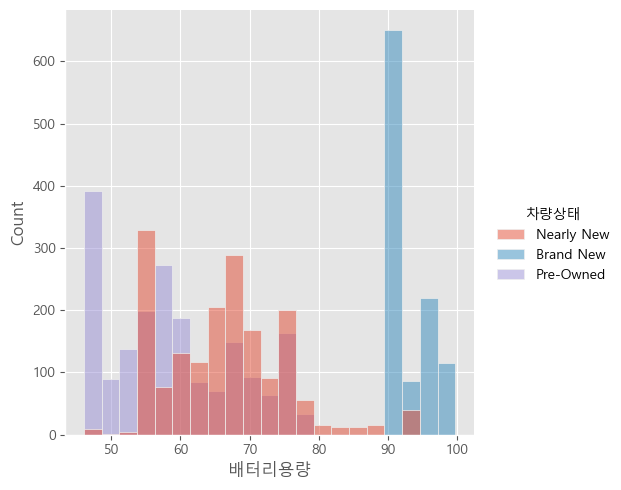

In [21]:
sns.displot(x=train['배터리용량'],hue=train['차량상태'])

<Axes: xlabel='배터리용량', ylabel='주행거리(km)'>

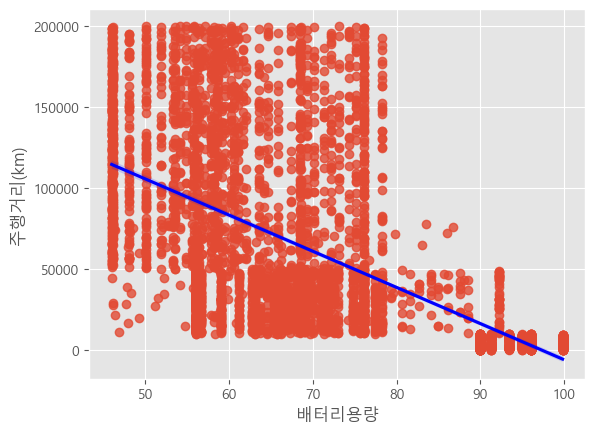

In [22]:
sns.regplot(x=df_missing_train['배터리용량'],y=df_missing_train['주행거리(km)'],line_kws={'color':'blue'})

<Axes: xlabel='가격(백만원)', ylabel='Count'>

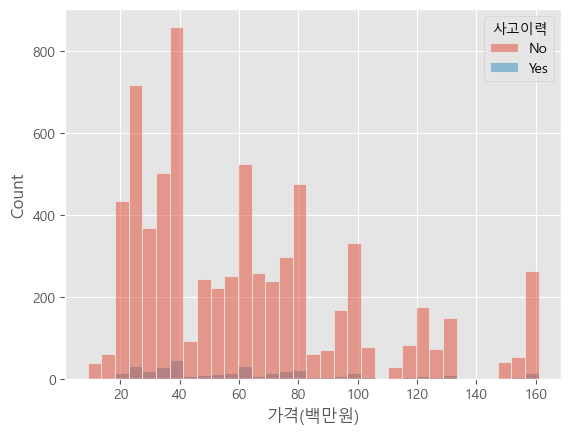

In [23]:
sns.histplot(x=train['가격(백만원)'],hue=train['사고이력'])

In [24]:
df_missing_train

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
4,TRAIN_0004,B,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02
5,TRAIN_0005,H,ION6,Pre-Owned,58.162,AWD,103100,3,No,0,37.02
...,...,...,...,...,...,...,...,...,...,...,...
7486,TRAIN_7486,A,eT,Brand New,91.200,AWD,602,7,No,0,65.57
7487,TRAIN_7487,H,IONIQ,Nearly New,67.170,FWD,29028,3,No,1,11.39
7493,TRAIN_7493,B,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40
7495,TRAIN_7495,B,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00


<Axes: xlabel='배터리용량', ylabel='가격(백만원)'>

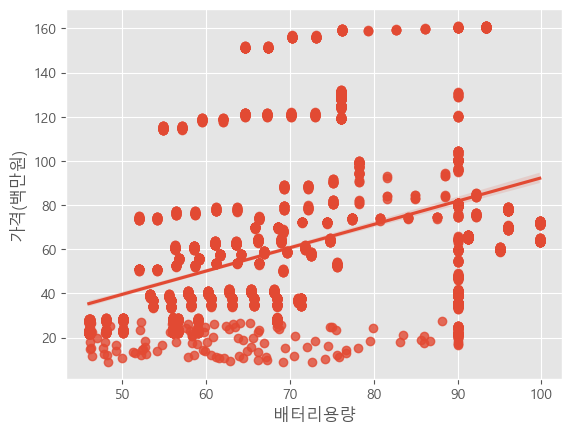

In [25]:
sns.regplot(y=train['가격(백만원)'],x=train['배터리용량'])

### 5. 구동방식
- 분포에는 크게 차이는 없다. AWD의 가격이 많이 높다

<Axes: ylabel='가격(백만원)'>

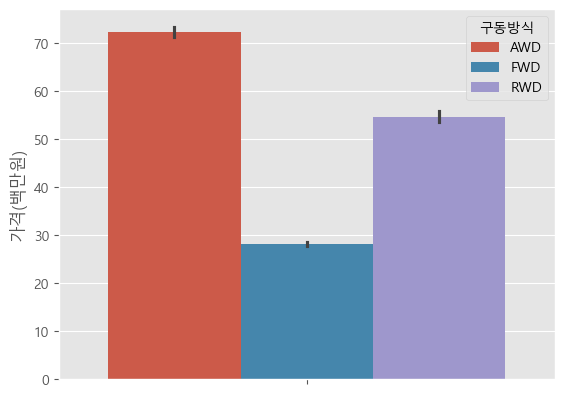

In [26]:
sns.barplot(y=train['가격(백만원)'],hue=train['구동방식'])

### 6. 주행거리(km)
- 주행거리 10000km이하가 전체의 절반 이상을 차지함.

<Axes: xlabel='주행거리(km)', ylabel='가격(백만원)'>

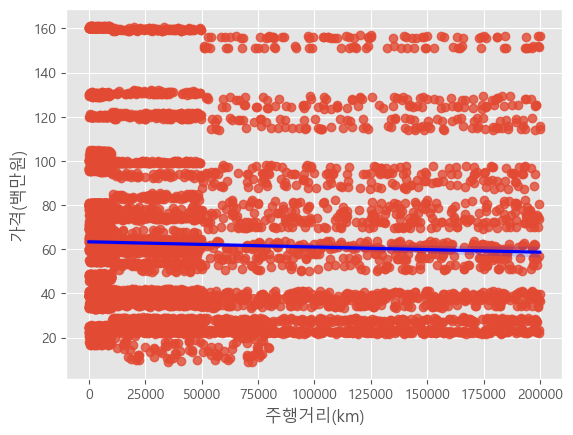

In [27]:
sns.regplot(data=train,x='주행거리(km)',y='가격(백만원)',line_kws={'color':'blue'})

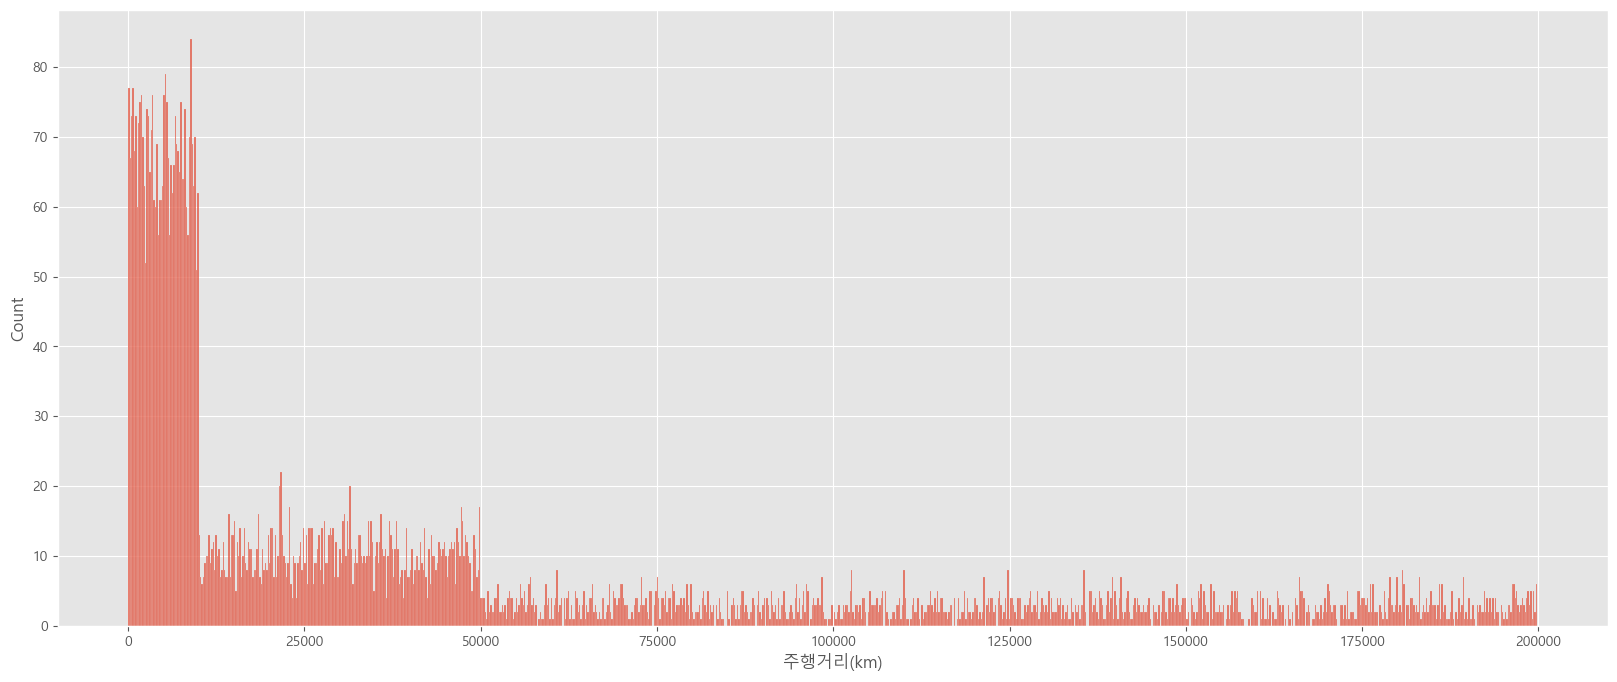

In [28]:
plt.figure(figsize=(20,8))
sns.histplot(train['주행거리(km)'],bins=1000)
plt.xscale('linear')

(7497, 11)

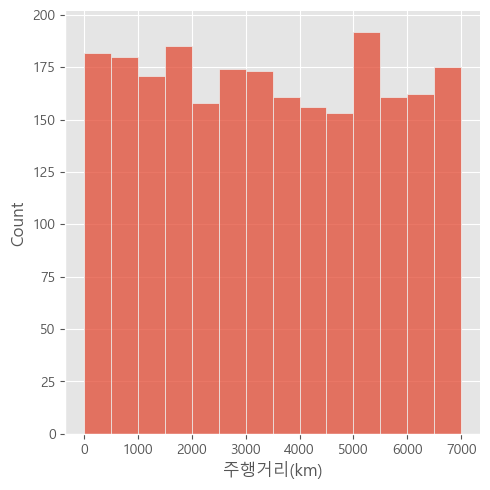

In [29]:
sns.displot(train.loc[train['주행거리(km)']<7000,'주행거리(km)'])
train.shape

## Feature Engineering
- 종속변수에 가장 상관관계 -> 배터리용량 / 보증기간

In [30]:
df_c = train.copy()
train_ID = df_c['ID']

df1_c = test.copy()
test_ID = df1_c['ID']

df_c.drop('ID',axis=1,inplace=True)
df1_c.drop('ID',axis=1,inplace=True)

df_c.corr(numeric_only=True)

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.576538,0.558242,-0.021845,0.431668
주행거리(km),-0.576538,1.000000,-0.664071,-0.089586,-0.035488
보증기간(년),0.558242,-0.664071,1.000000,0.035294,-0.349962
연식(년),-0.021845,-0.089586,0.035294,1.000000,-0.058455
가격(백만원),0.431668,-0.035488,-0.349962,-0.058455,1.000000


slinear interpolation


import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

missing_indices = df_c[df_c['배터리용량'].isna()].index
missing_indices_t= df1_c[df1_c['배터리용량'].isna()].index

df_non_missing = df_c.dropna(subset=['배터리용량'])
df_non_missing_t = df1_c.dropna(subset=['배터리용량'])

interp_func = interp1d(df_non_missing.index, df_non_missing['배터리용량'], kind='slinear')
interp_func_t = interp1d(df_non_missing_t.index, df_non_missing_t['배터리용량'], kind='slinear')

df_c.loc[missing_indices, '배터리용량'] = interp_func(missing_indices)
df1_c.loc[missing_indices_t, '배터리용량'] = interp_func_t(missing_indices_t)

print(df_c['배터리용량'].isna().sum())
print(df1_c['배터리용량'].isna().sum())

주행 거리에 따른 등급 feature 추가(A,B,C)
- A:0~10000
- B:10000~50000
- C:50000이상 

In [31]:
#for i in [df_c,df1_c]:
#    i['run_dis'] = 'A'
#    i.loc[i['주행거리(km)']>50000,'run_dis'] = 'C'
#    i.loc[(i['주행거리(km)']<=50000)&(i['주행거리(km)']>=10000),'run_dis'] = 'B'

#cat_col.append('run_dis')

Label Encoding for Categorical Data

In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_c[cat_col] = df_c[cat_col].apply(lambda x: le.fit_transform(x))
df1_c[cat_col] = df1_c[cat_col].apply(lambda x: le.fit_transform(x))

주행거리(km),연식(년)의 skewness가 높아서 이를 log 정규화를 통한 정제

print('주행거리 skewness :',df_c['주행거리(km)'].skew())
from sklearn.preprocessing import MinMaxScaler

rc = MinMaxScaler()

df_c['주행거리(km)'] = rc.fit_transform(df_c['주행거리(km)'].values.reshape(-1,1))
df1_c['주행거리(km)'] = rc.transform(df1_c['주행거리(km)'].values.reshape(-1,1))
print('주행거리 log 변환 후 skewness :',df_c['주행거리(km)'].skew())

c:\Anaconda3\envs\vscode_jupyter\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

c:\Anaconda3\envs\vscode_jupyter\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Anaconda3\envs\vscode_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


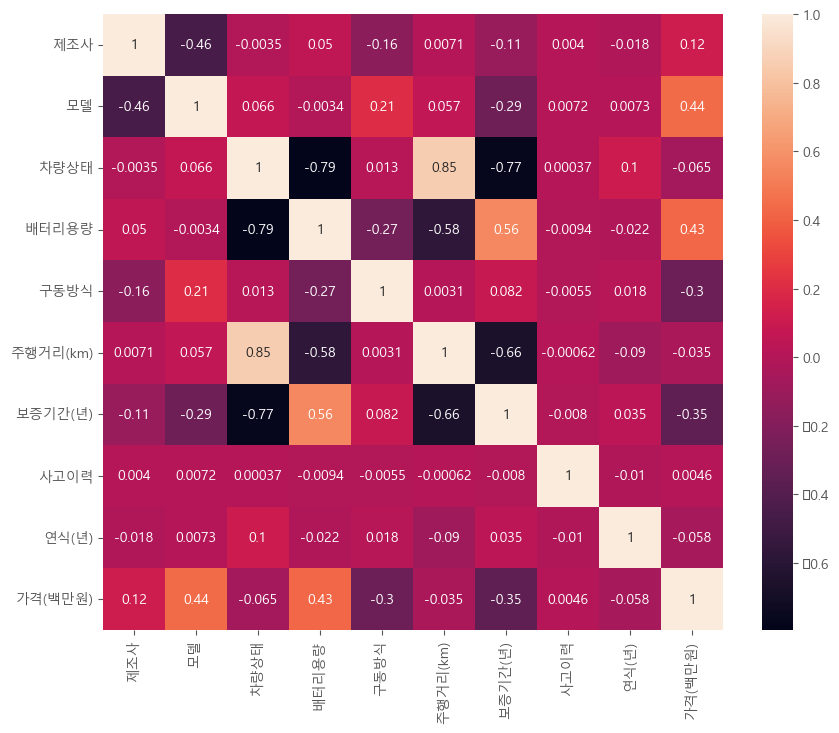

In [33]:
plt.figure(figsize=(10,8))
sns.heatmap(df_c.corr(),annot=True)

Data 나누기

In [77]:
print(df_c.shape,df1_c.shape)
X,y = df_c.drop(columns=['가격(백만원)']),df_c['가격(백만원)']
X_test = df1_c

(7497, 9) (846, 8)


## 모델 탐색

### XGBRegressor
- xgboost 자체 처리: 1.473 (파라미터 설정 X => n_est:100,lr:0.3)

- ~~xgboost 자체 처리: 1.57(파라미터 설정 O)~~
- ~~'run_dis' column 추가: 1.4673~~
- ~~slinear interpolation: 1.473 (파라미터 설정 X)~~
- ~~0으로 결측치 처리: 1.48(파라미터 설정X)~~
- ~~train의 평균값으로 대체 : 1.52~~
- ~~종속변수의 log1p 분포 변환:~~ 
- ~~train column에 scaling 변환~~

In [116]:
from optuna import Trial,visualization
from optuna.samplers import TPESampler
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error


def objectivexgr(trial:Trial,X,y):
    global param
    param = {'random_state':42,
             'n_estimators':trial.suggest_int('n_estimators',100,1500),
             'learning_rate':trial.suggest_float('learning_rate',0.1,0.5),
             'max_depth':trial.suggest_int('max_depth',3,10),
             'min_child_weight':trial.suggest_int('min_child_weight',1,3)}
    model = XGBRegressor(**param)
    xgb_model = model.fit(X,y,verbose=False)
    answer = xgb_model.predict(X)
    score = root_mean_squared_error(y,answer)

    return score

In [117]:
#아무것도 없을 때 0.8264
study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=2024))

study.optimize(lambda trial: objectivexgr(trial,df_c.drop(columns=['가격(백만원)']),df_c['가격(백만원)']),n_trials=50)
print('Best trial: score: {}, \nparmas: {}'.format(study.best_trial.value,study.best_trial.params))

[I 2025-01-15 16:36:34,093] A new study created in memory with name: no-name-427d6a94-2254-4869-b639-b1e381baeb4a
[I 2025-01-15 16:36:34,642] Trial 0 finished with value: 0.697942503928791 and parameters: {'n_estimators': 923, 'learning_rate': 0.37964349907263306, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 0 with value: 0.697942503928791.
[I 2025-01-15 16:36:35,180] Trial 1 finished with value: 0.6722593254132656 and parameters: {'n_estimators': 387, 'learning_rate': 0.1424251497905063, 'max_depth': 8, 'min_child_weight': 3}. Best is trial 1 with value: 0.6722593254132656.
[I 2025-01-15 16:36:35,592] Trial 2 finished with value: 1.023788693918868 and parameters: {'n_estimators': 763, 'learning_rate': 0.27931832979212184, 'max_depth': 3, 'min_child_weight': 3}. Best is trial 1 with value: 0.6722593254132656.
[I 2025-01-15 16:36:37,204] Trial 3 finished with value: 0.5719794624837282 and parameters: {'n_estimators': 944, 'learning_rate': 0.4847110301232759, 'max_depth': 8, 'mi

Best trial: score: 0.5719429885038712, 
parmas: {'n_estimators': 564, 'learning_rate': 0.394035387088425, 'max_depth': 10, 'min_child_weight': 1}


In [95]:
optuna.visualization.plot_optimization_history(study)

In [118]:
import numpy as np
from sklearn.model_selection import KFold
folds = KFold(n_splits=5,shuffle=True,random_state=2025)

test_prediction = np.zeros(len(X_test))
val_scores = []

for idx,(train_idx,val_idx) in enumerate(folds.split(X,y)):
    print(f'Fold {idx+1} / Fold {folds.n_splits}')
    X_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
    X_val,y_val = X.iloc[val_idx],y.iloc[val_idx]

    xgb_model = XGBRegressor(**study.best_params)

    xgb_model.fit(X_train,y_train)

    train_y_pred = xgb_model.predict(X_train)
    val_y_pred = xgb_model.predict(X_val)

    print(f'Train RMSE: {root_mean_squared_error(y_train,train_y_pred)}')
    print(f'Val RMSE: {root_mean_squared_error(y_val,val_y_pred)}')
    print('-'*30)

    #Average of the Fold's Prediction for test data(X_test) => using as the submission
    test_prediction += xgb_model.predict(X_test) / folds.n_splits   #5-fold
    y_preds = xgb_model.predict(X_val)
    val_scores.append(root_mean_squared_error(y_val,y_preds))

print(f'RMSE: {np.array(val_scores).mean()}')

Fold 1 / Fold 5
Train RMSE: 0.5151430709192489
Val RMSE: 1.5286280906680563
------------------------------
Fold 2 / Fold 5
Train RMSE: 0.508260538504207
Val RMSE: 1.6483501910087892
------------------------------
Fold 3 / Fold 5
Train RMSE: 0.5126596780447107
Val RMSE: 1.7678062933921124
------------------------------
Fold 4 / Fold 5
Train RMSE: 0.4934709975892588
Val RMSE: 1.5977993378962718
------------------------------
Fold 5 / Fold 5
Train RMSE: 0.4884193754814245
Val RMSE: 1.6776947919864014
------------------------------
RMSE: 1.6440557409903263


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

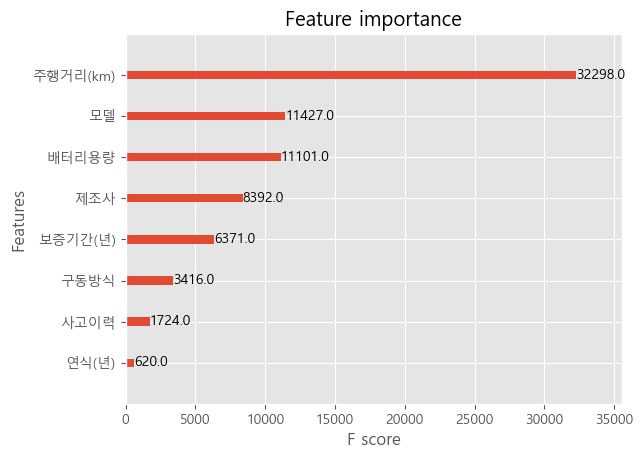

In [119]:
import xgboost
xgboost.plot_importance(xgb_model)

### Light-GBM
- 아무 전처리X : 1.357(실제로는 XGB보다 낮음)

In [263]:
from optuna import Trial,visualization
from optuna.samplers import TPESampler
import optuna

from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_error

def objectivelgb(trial:Trial,X,y):
    global lgb_param
    lgb_param ={'random_state':2025}

    lgb_model = LGBMRegressor(**param,force_col_wise=True)
    lgb_model.fit(X,y)

    pred = lgb_model.predict(X)
    score = root_mean_squared_error(y,pred)

    return score

In [341]:
study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=2025))

study.optimize(lambda trial: objectivelgb(trial,df_c.drop(columns=['가격(백만원)']),df_c['가격(백만원)']),n_trials=10)
print('Best trial: score: {}, \nparmas: {}'.format(study.best_trial.value,study.best_trial.params))

[I 2025-01-12 15:33:13,585] A new study created in memory with name: no-name-4d4a7f6f-1f64-404d-92f3-d741c72bcad3


[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949


[I 2025-01-12 15:33:14,415] Trial 0 finished with value: 1.1396787273940583 and parameters: {}. Best is trial 0 with value: 1.1396787273940583.


[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949


[I 2025-01-12 15:33:14,630] Trial 1 finished with value: 1.1396787273940583 and parameters: {}. Best is trial 0 with value: 1.1396787273940583.


[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949


[I 2025-01-12 15:33:14,867] Trial 2 finished with value: 1.1396787273940583 and parameters: {}. Best is trial 0 with value: 1.1396787273940583.


[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949


[I 2025-01-12 15:33:15,083] Trial 3 finished with value: 1.1396787273940583 and parameters: {}. Best is trial 0 with value: 1.1396787273940583.


[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949


[I 2025-01-12 15:33:15,413] Trial 4 finished with value: 1.1396787273940583 and parameters: {}. Best is trial 0 with value: 1.1396787273940583.


[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949


[I 2025-01-12 15:33:15,626] Trial 5 finished with value: 1.1396787273940583 and parameters: {}. Best is trial 0 with value: 1.1396787273940583.
[I 2025-01-12 15:33:15,827] Trial 6 finished with value: 1.1396787273940583 and parameters: {}. Best is trial 0 with value: 1.1396787273940583.


[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949


[I 2025-01-12 15:33:16,029] Trial 7 finished with value: 1.1396787273940583 and parameters: {}. Best is trial 0 with value: 1.1396787273940583.


[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949


[I 2025-01-12 15:33:16,266] Trial 8 finished with value: 1.1396787273940583 and parameters: {}. Best is trial 0 with value: 1.1396787273940583.


[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949


[I 2025-01-12 15:33:16,552] Trial 9 finished with value: 1.1396787273940583 and parameters: {}. Best is trial 0 with value: 1.1396787273940583.


Best trial: score: 1.1396787273940583, 
parmas: {}


In [264]:
import numpy as np
from sklearn.model_selection import KFold
folds = KFold(n_splits=5,shuffle=True,random_state=2025)

val_scores_lgb = []
test_pred_lgb = np.zeros(len(test))

for idx,(train_idx,val_idx) in enumerate(folds.split(X,y)):
    print(f'Fold: {idx+1} / Fold: {folds.n_splits}')
    X_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
    X_val,y_val = X.iloc[val_idx],y.iloc[val_idx]

    lgb = LGBMRegressor(**study.best_params,force_col_wise=True)
    lgb_model = lgb.fit(X_train,y_train)

    train_y_pred = lgb_model.predict(X_train)
    val_y_pred = lgb_model.predict(X_val)

    print(f'Train RMSE: {root_mean_squared_error(y_train,train_y_pred)}')
    print(f'Val RMSE: {root_mean_squared_error(y_val,val_y_pred)}')
    print('-' * 30)

    test_pred_lgb += lgb_model.predict(X_test) / folds.n_splits
    val_scores_lgb.append(root_mean_squared_error(val_y_pred,y_val))

print(f'Average RMSE: {np.array(val_scores_lgb).mean()}')

Fold: 1 / Fold: 5
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 5997, number of used features: 8
[LightGBM] [Info] Start training from score 62.548199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

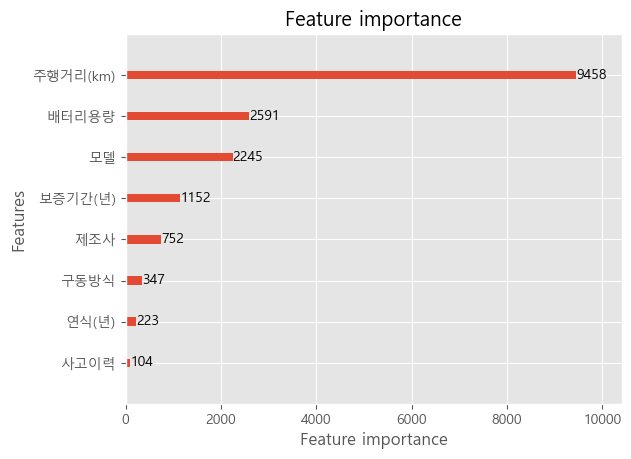

In [265]:
from lightgbm import plot_importance
plot_importance(lgb_model)

### Ensemble (lightgbm & xgboost)

In [344]:
test_ensemble_pred = test_pred_lgb * 0.5 + test_prediction * 0.5

## 결과물 제출

In [120]:
submit.loc[submit['ID'].isin(test_ID),'가격(백만원)'] = test_prediction
submit.to_csv('submit_log1p주행거리_carstatus_hyperparam_xgb.csv',index=False)

In [121]:
submit.head()

,ID,가격(백만원)
0,TEST_000,130.534311
1,TEST_001,80.010132
2,TEST_002,65.243496
3,TEST_003,34.574137
4,TEST_004,48.049588
